In [22]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from random import randint
import cv2
import csv

In [23]:
path = '/home/yauheni/source/repos/jubilant-funicular/lab1/discuss.png'
data = cv2.imread(path)


In [24]:
def m_dot(X, Y):
    # if X.shape[1] != Y.shape[0]:
    #     return None
    return [[sum(a * b for a, b in zip(X_ROW, Y_COL)) for Y_COL in zip(*Y)] for X_ROW in X]


def m_t(M):
    return [[M[j][i] for j in range(len(M))] for i in range(len(M[0]))]

In [25]:

def get_shape(path):
    img_matrix = cv2.imread(path)
    return img_matrix.shape, img_matrix.reshape(-1).shape[0]


def get_blocks_params(horizontal_compression, vertical_compression, img_size):
    h_blocks_num = img_size // horizontal_compression
    v_blocks_num = img_size // vertical_compression
    return h_blocks_num, v_blocks_num, h_blocks_num * v_blocks_num


def normalize_data(data):
    return np.asarray(data) / 255


In [26]:
n, m, size = int(input()), int(input()), get_shape(path)[0][1]
vertical, horizontal, blocks_num = get_blocks_params(n, m, size)


In [27]:
images_num = 2000  # кол-во повторений картинки

data = np.zeros((blocks_num * images_num, n*m*3))
pic = normalize_data(cv2.imread(path))

for img_i in range(images_num):
    for v_i in range(vertical):
        for h_i in range(horizontal):
            data[blocks_num * img_i + horizontal * v_i + h_i, :] = pic[m * v_i: m * (v_i + 1), n * h_i: n *
                                                                       (h_i + 1), :].reshape(n*m*3) * 2 - 1


In [28]:
class NeuralNetwork():
    def __init__(self, n: int = 16, m: int = 16, alpha: float = 5*10e-5) -> None:
        self.alpha = alpha
        self.W1 = np.random.normal(0.0, pow(3*m*n//3, -0.5), (3*m*n, 3*m*n//3))
        self.W2 = self.W1.T

    def compression(self, X):
        splitted_pic = []
        # split image into squares
        for j in range(vertical):
            for k in range(horizontal):
                splitted_pic.append(
                    X[m*j:m*(j+1), n*k:n*(k+1), :].reshape(n*m*3)*2-1)
        encoded_pic = []
        # encode pic
        for i in splitted_pic:
            encoded_pic.append(i@self.W1)
        X = np.array(encoded_pic)

        pic = np.zeros((size, size, 3))
        for i in range(vertical):
            for j in range(horizontal):
                pic[i*m:(i+1)*m, j*n:(j+1)*n] = (X[i*m+j]
                                                 @ self.W2).reshape(16, 16, 3)
        pic = (pic+1)/2
        return pic

    def back_propagation(self, X):
        compressed = (X@self.W1)[np.newaxis]
        output = np.dot(compressed, self.W2)
        error = (output - X)
        self.W2 -= self.alpha*np.dot(compressed.T, error)
        X = X[np.newaxis]
        self.W1 -= self.alpha*np.dot(np.dot(X.T, error), self.W2.T)
        return np.abs(error).sum()

        #compressed = m_dot(X, self.W1)
        #compressed = compressed[np.newaxis]

        # output = m_dot(compressed, self.W2)

        #self.W2 -= self.alpha * m_dot(m_t(compressed), error)

        #self.W1 -= self.alpha * m_dot(m_dot(m_t(X), error), m_t(self.W2))

    def save(self):
        with open("w1.csv", "+w") as data:
            writer = csv.writer(data, delimiter=',')
            writer.writerows(self.W1)

    def load(self):
        self.W1 = np.loadtxt(open('w1.csv'), delimiter=',')
        self.W2 = self.W1.T


In [29]:
nn = NeuralNetwork()

print('Load previous weights?(y/n)')
res = str(input())
if res == 'y':
  nn.load()
else:
  number_of_trainings = 100
  train = data[:number_of_trainings]
  errors = []
  counter = 0
  for image in train:
    errors.append(nn.back_propagation(image))
  
  

Load previous weights?(y/n)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Save current weights?(y/n)


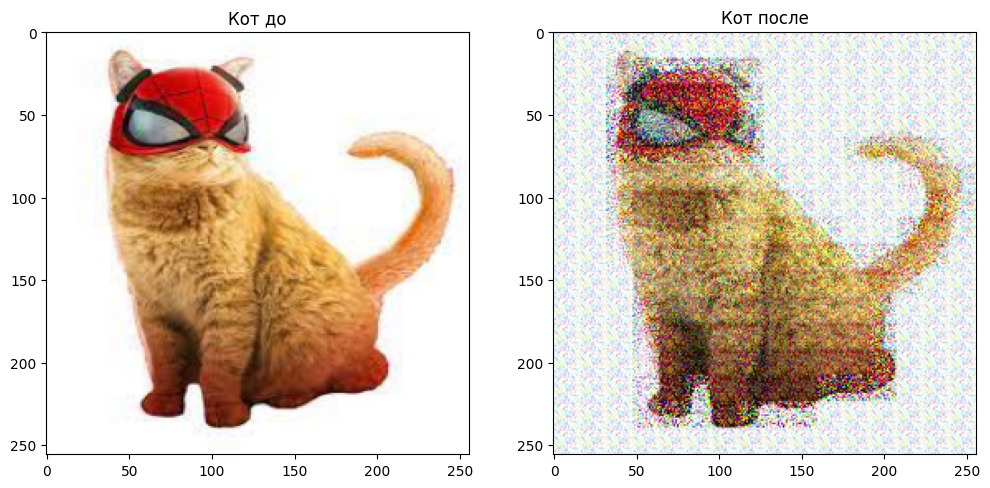

In [30]:
matplotlib.rcParams['figure.figsize'] = [12, 12]

pic = mpimg.imread(
    '/home/yauheni/source/repos/jubilant-funicular/lab1/discuss.png')
test = nn.compression(pic)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(pic)
axs[1].imshow(test)
axs[0].set_title("Кот до")
axs[1].set_title("Кот после")

print('Save current weights?(y/n)')
sv = str(input())
if sv == 'y':
    nn.save()
